# libraries

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import copy
import logging
import missingno
from collections import Counter
import random

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    learning_curve,
    KFold
)
from sklearn.preprocessing import (
    LabelEncoder,
    OrdinalEncoder,
    StandardScaler,
    Normalizer,
    RobustScaler
)
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet
)
from imblearn.over_sampling import (
    SMOTE,
    RandomOverSampler
)
from imblearn.under_sampling import (
    TomekLinks, 
    RandomUnderSampler
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import (
    KNeighborsClassifier,
    KNeighborsRegressor,
    NearestNeighbors
)
from sklearn.svm import (
    SVC,
    SVR
)
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor
)
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier,
    RandomForestRegressor,
    BaggingRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
    StackingRegressor
)
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    matthews_corrcoef,
    balanced_accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from scipy.stats import uniform, randint
from fast_ml.model_development import train_valid_test_split
from typing import (
    Any,
    Union,
    List,
    Optional,
    Dict,
    Tuple,
    Literal)

# reading the data

In [2]:
file_path = r'train.csv'
data = pd.read_csv(file_path)

# Taking a deepcopy of the data

In [3]:
df = copy.deepcopy(data)
df.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,1,49,management,married,secondary,no,104,yes,no,unknown,8,may,285,1,-1,0,unknown,no
1,2,59,retired,divorced,secondary,no,514,no,no,cellular,3,feb,261,1,-1,0,unknown,yes
2,3,33,blue-collar,married,primary,no,195,no,no,cellular,16,nov,984,5,-1,0,unknown,yes
3,4,58,unemployed,married,secondary,no,687,yes,no,cellular,7,aug,221,1,99,2,success,yes
4,5,33,admin.,married,secondary,no,1077,yes,no,cellular,18,may,432,3,374,3,other,no


# Drop columns that aren't useful

In [4]:
column_name = ['ID']
df.drop(column_name,axis=1,inplace=True)

# determine the names of Numeric Feature

In [5]:
numeric_feature = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numeric_feature)
print(len(numeric_feature))

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
7


# determine the names of categorical Feature

In [6]:
categorical_feature = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
print(categorical_feature)
print(len(categorical_feature))

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']
10


# Check for missing values

In [7]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

# Check for duplicated rows

In [8]:
df.duplicated().sum()

0

# check for unbalance data

In [9]:
target = 'deposit'
df[target].value_counts()

deposit
no     4668
yes    4261
Name: count, dtype: int64

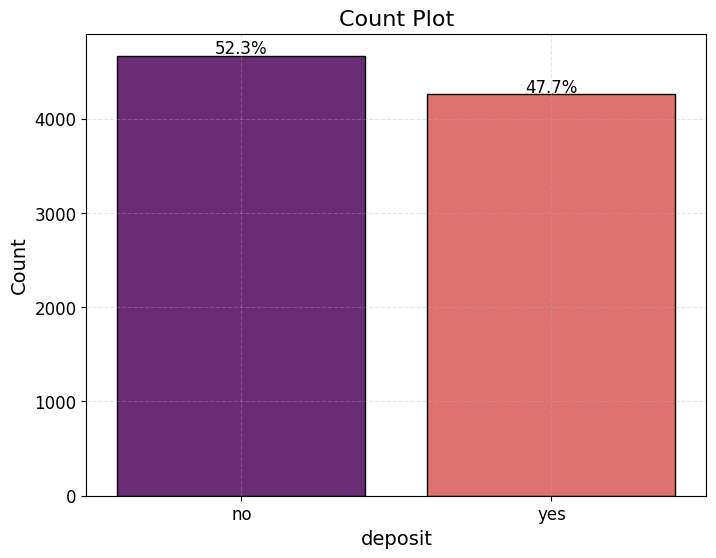

In [10]:
# Plot the count plot
plt.figure(figsize=(8, 6))  # Set the figure size
ax = sns.countplot(data=df, 
                x=target, 
                palette='magma', 
                order=df[target].value_counts().index, 
                edgecolor='black')
# Add percentages on the bars
total = len(df[target])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=12, 
                color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.xlabel(target, fontsize=14)  # Set x-axis label with font size
plt.ylabel('Count', fontsize=14)  # Set y-axis label with font size
plt.title('Count Plot', fontsize=16)  # Set title with font size
plt.grid(True, linestyle='--', linewidth=0.8, alpha=0.3)  # Add grid lines with custom style
plt.xticks(fontsize=12)  # Set font size for x-axis ticks
plt.yticks(fontsize=12)  # Set font size for y-axis ticks
plt.show()

# statistical questions

In [11]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,49,management,married,secondary,no,104,yes,no,unknown,8,may,285,1,-1,0,unknown,no
1,59,retired,divorced,secondary,no,514,no,no,cellular,3,feb,261,1,-1,0,unknown,yes
2,33,blue-collar,married,primary,no,195,no,no,cellular,16,nov,984,5,-1,0,unknown,yes
3,58,unemployed,married,secondary,no,687,yes,no,cellular,7,aug,221,1,99,2,success,yes
4,33,admin.,married,secondary,no,1077,yes,no,cellular,18,may,432,3,374,3,other,no


In [12]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000
mean,41.249972,1515.159256,15.605555,371.089036,2.511703,51.641841,0.848695
std,11.934456,3166.676380,8.403953,346.656840,2.680722,108.706199,2.364959
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,127.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,545.000000,15.000000,254.000000,2.000000,-1.000000,0.000000
75%,49.000000,1684.000000,21.000000,496.000000,3.000000,42.000000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [13]:
df.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,8929,8929,8929,8929,8929,8929,8929,8929,8929,8929
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2027,5115,4393,8789,4717,7750,6427,2278,6643,4668


## what is the minimum age we have ?

In [14]:
df['age'].min()

18

## what is the maximum duration we have ?

In [15]:
df['duration'].max()

3881

## what is the average pdayes we have ?

In [16]:
df['pdays'].mean()

51.6418411916228

# Check for Outliers




In [17]:
def box_plot_seaborn(
    data, x: Optional[str] = None, y: Optional[str] = None, hue: Optional[str] = None, 
    palette: str = 'magma',palette2: str = 'viridis',color=None, figsize: tuple = (8, 6), width: float = 0.5, whis: float = 1.5, 
    notch: bool = True, showmeans: bool = True, mean_marker: str = 'o', mean_color: str = 'black', 
    flier_marker: str = 'o', flier_size: int = 8, flier_color: str = 'black', flier_edge_color: str = 'purple', 
    xlabel: str = 'Groups', ylabel: str = 'Values', title: str = 'Box Plot (Seaborn)', 
    xtick_labels: Optional[List[str]] = None, font_scale: float = 1, orient: Optional[Literal['v', 'h', 'x', 'y']] = None
) -> None:
    """
    Create a box plot using Seaborn with the provided parameters.

    Parameters:
    - data: DataFrame
        The dataset for plotting.
    - x: str, optional
        Column name for x-axis variable.
    - y: str, optional
        Column name for y-axis variable.
    - hue: str, optional
        Column name for grouping variable to produce multiple plots.
    - palette: str
        Color palette for the plot.
    - figsize: tuple
        Size of the figure (width, height).
    - width: float
        Width of the box in the boxplot.
    - whis: float
        Whisker length in terms of IQR.
    - notch: bool
        Whether to draw a notch to indicate the confidence interval.
    - showmeans: bool
        Whether to show the mean value in the plot.
    - mean_marker: str
        Marker style for the mean value.
    - mean_color: str
        Color of the mean marker.
    - flier_marker: str
        Marker style for outliers.
    - flier_size: int
        Size of the outlier markers.
    - flier_color: str
        Color of the outlier markers.
    - flier_edge_color: str
        Edge color of the outlier markers.
    - xlabel: str
        Label for the x-axis.
    - ylabel: str
        Label for the y-axis.
    - title: str
        Title of the plot.
    - xtick_labels: list of str, optional
        Custom labels for the x-axis ticks.
    - font_scale: float
        Scaling factor for the font size of all text elements.
    - orient: {'v', 'h', 'x', 'y'}, optional
        Orientation of the plot (vertical or horizontal).
    
    Returns:
    - None
    """

    # Set font scale for all text elements and styling
    sns.set(font_scale=font_scale, style='white')

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # get the color for each plot
    if color is None:
        colors_list = random.sample(sns.color_palette(palette) + sns.color_palette(palette2), 12)
        colors = random.choices(colors_list, k=1)
    else:
        colors = color
    
    # Create the boxplot with the specified parameters
    if hue is not None:
        sns_plot = sns.boxplot(
            data=data, x=x, y=y, hue=hue, palette=palette, width=width, 
            whis=whis, notch=notch, showmeans=showmeans, orient=orient,
            meanprops=dict(marker=mean_marker, markerfacecolor=mean_color, markeredgecolor=mean_color),
            flierprops=dict(marker=flier_marker, markersize=flier_size, 
                            markerfacecolor=flier_color, markeredgecolor=flier_edge_color),
            ax=ax
        )
    elif hue is None and x is None and y is None:
        sns_plot = sns.boxplot(
            data=data, palette=palette, width=width, 
            whis=whis, notch=notch, showmeans=showmeans, orient=orient,
            meanprops=dict(marker=mean_marker, markerfacecolor=mean_color, markeredgecolor=mean_color),
            flierprops=dict(marker=flier_marker, markersize=flier_size, 
                            markerfacecolor=flier_color, markeredgecolor=flier_edge_color),
            ax=ax
        )
    elif hue is None:
        sns_plot = sns.boxplot(
            data=data, x=x, y=y, color=colors[0], width=width, 
            whis=whis, notch=notch, showmeans=showmeans, orient=orient,
            meanprops=dict(marker=mean_marker, markerfacecolor=mean_color, markeredgecolor=mean_color),
            flierprops=dict(marker=flier_marker, markersize=flier_size, 
                            markerfacecolor=flier_color, markeredgecolor=flier_edge_color),
            ax=ax
        )
    
    
    # Set labels and title
    ax.set_xlabel(xlabel, fontsize=14 * font_scale)
    ax.set_ylabel(ylabel, fontsize=14 * font_scale)
    ax.set_title(title, fontsize=16 * font_scale)

    # Set custom x-axis tick labels if provided
    if xtick_labels:
        ax.set_xticks(range(len(xtick_labels)))
        ax.set_xticklabels(xtick_labels, fontsize=12 * font_scale)

    # Set y-axis tick font size
    ax.tick_params(axis='y', labelsize=12 * font_scale)

    # Add grid lines to the plot
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    # Add a legend if a hue is used and there are labeled artists
    if hue and sns_plot.get_legend_handles_labels()[0]:
        ax.legend(title=hue, loc='upper right', fontsize=10 * font_scale)
    elif hue:
        print(f"Note: No legend created as no artists with labels were found for hue '{hue}'.")

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()



In [18]:
outliers_df=df.drop(df.select_dtypes(exclude=['int64', 'float64']).columns.tolist(),axis=1)
# Calculate the first and third quartiles of the data
q1, q3 = np.percentile(outliers_df, [25, 75])

# Calculate the IQR
iqr = q3 - q1

# Calculate the lower and upper bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify the outliers
outliers = (outliers_df < lower_bound) | (outliers_df > upper_bound)

# Print the outliers
outliers_df[outliers].count()

age            0
balance     6027
day            0
duration    4065
campaign       0
pdays        575
previous       0
dtype: int64

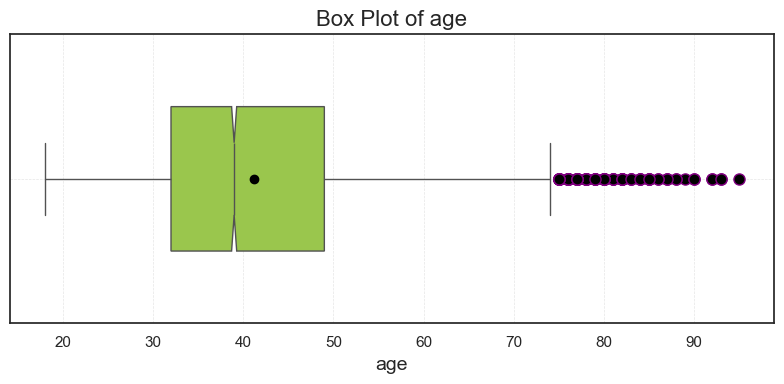

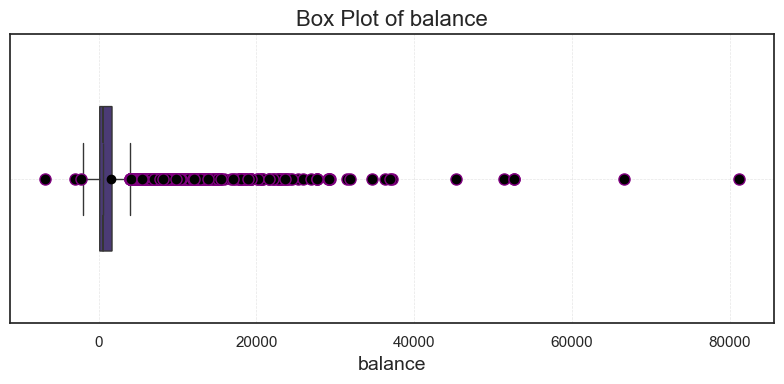

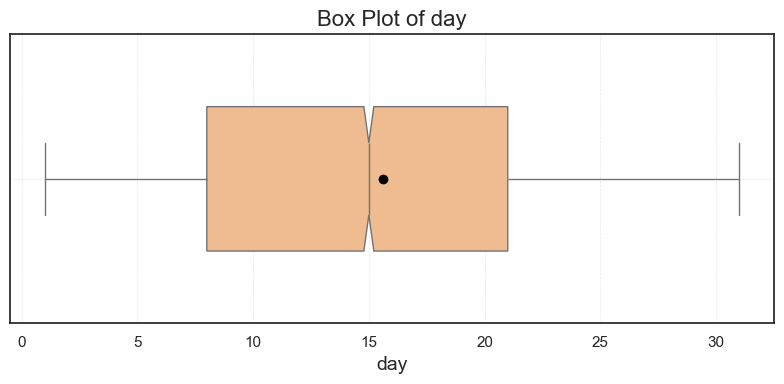

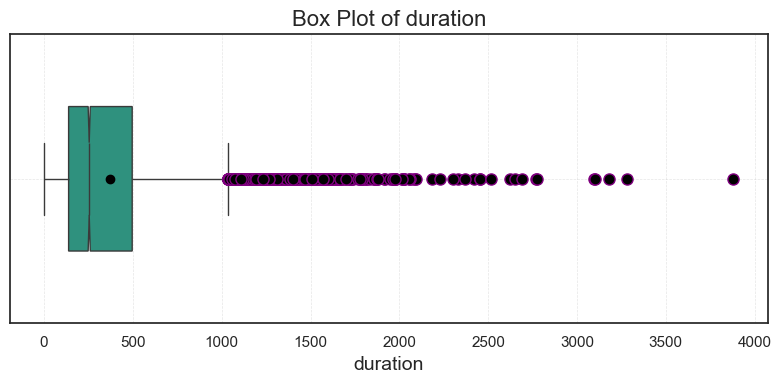

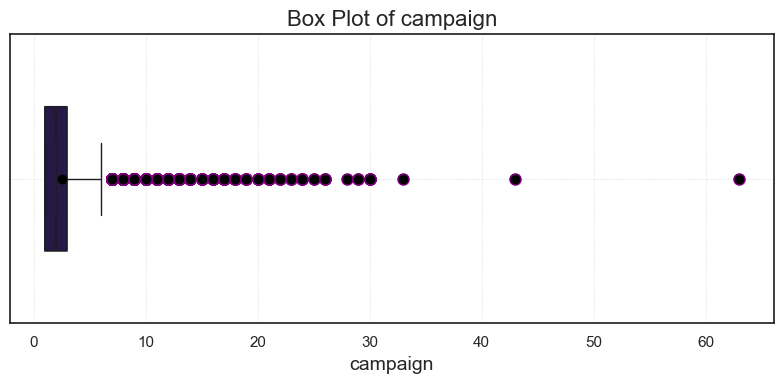

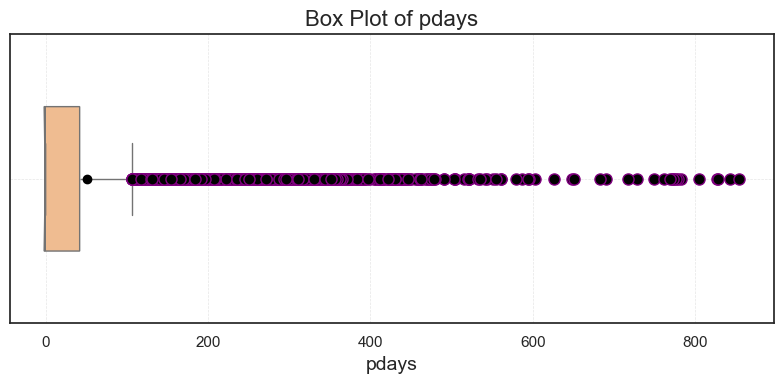

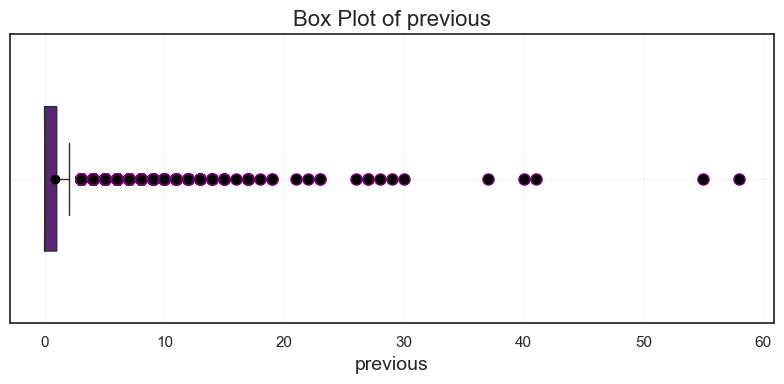

In [19]:
for coloum in numeric_feature:
    box_plot_seaborn(data=df,x=coloum,orient='y',xlabel=coloum,ylabel=None,title='Box Plot of '+coloum ,figsize=(8,4))

# I want the names of the jobs that are the largest in number in descending order (in graph)

In [20]:
def bar_plot_matplotlib(
    x, y, 
    palette='magma', 
    palette2='viridis',
    color=None,
    width=0.75, 
    edgecolor='black', 
    xlabel=None, 
    ylabel=None, 
    title=None, 
    hatches:list=None,
    hatch:bool=True,
    order=False,
    x_rotation = 45,
    figsize = (10, 8)
):
    """
    Creates a bar plot using matplotlib with customizable colors, hatches, and labels.
    
    Parameters:
    - x (list): Categories for the x-axis.
    - y (list): Values for the y-axis.
    - palette (str): Color palette for the bars (default is 'magma').
    - width (float): Width of the bars (default is 0.8).
    - edgecolor (str): Edge color of the bars (default is 'black').
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - title (str): Title of the plot.
    - hatches (list): List of hatches for the bars.
    - hatch (bool): to make hatches or not (default is True)
    - order (bool): Whether to order the bars by height (default is False).
    
    Returns:
    - None
    """
    plt.figure(figsize = figsize)
    
    if order:
        # Order the bars by the y-values
        x, y = zip(*sorted(zip(x, y), key=lambda pair: pair[1], reverse=True))
    if hatch is True:
        if not hatches:
            hatches = random.sample(['X', 'oo', 'O|', '/', '+', '++', '--', '-\\', 'xx', '*-', '\\\\', '|*', '\\', 'OO', 'o', '**', 'o-', '*', '//', '||', '+o', '..', '/o', 'O.', '\\|', 'x*', '|', '-', None], len(x))
    
    # get the color for each plot
    if color is None:
        if len(x) <= 6 :
            colors = random.sample(sns.color_palette(palette), len(x))
        elif len(x) <= 12 :
            colors = random.sample(sns.color_palette(palette) + sns.color_palette(palette2), len(x))
        elif len(x) > 12 :
            colors = random.choices(sns.color_palette(palette) + sns.color_palette(palette2), k=len(x))
    else:
        colors = [color] * len(x)
    
    # Create the bar plot
    bars = plt.bar(x, y, color=colors, hatch=hatches, width=width, edgecolor=edgecolor)
    
    # Set the labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.4)
    
    # Add legend
    plt.legend(bars, x, title=title)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0, f'{height}', ha='center', va='bottom', color='black')
    plt.xticks(rotation=x_rotation)
    
    # Display plot
    plt.show()



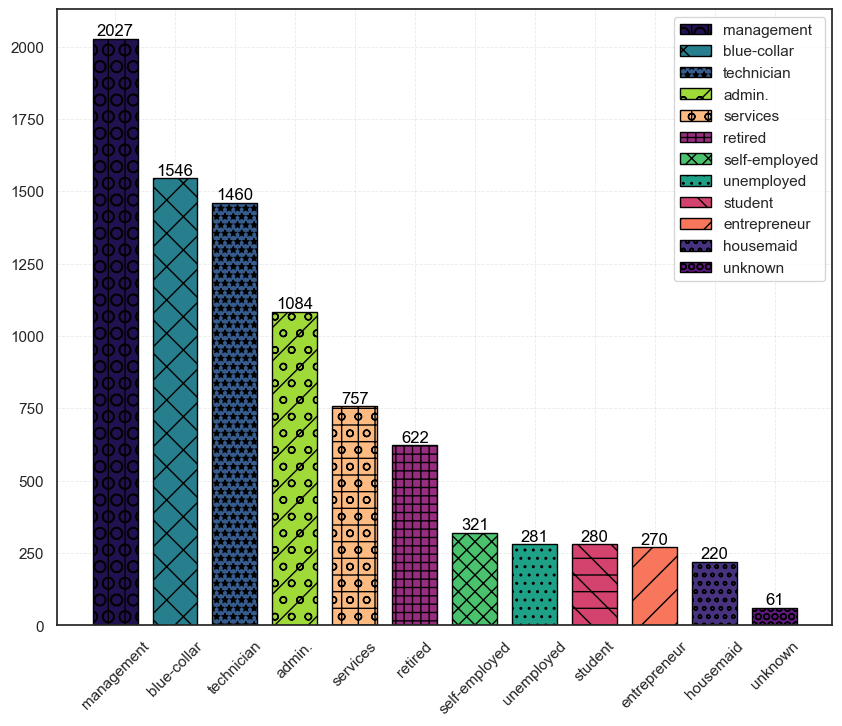

In [21]:
target_plot = 'job'
bar_plot_matplotlib(x=data[target_plot].value_counts().index,y=data[target_plot].value_counts().values,order=True)

# What is the largest number of people I have, married or single?(in graph)

In [22]:
def count_plot(df: pd.DataFrame = None, column_plot: Optional[str] = None, x=None, y=None, hue=None,
            palette='magma', edgecolor='black', order: bool = False, figsize=(8,6), 
            stat: Literal['count', 'percent', 'proportion', 'probability'] = "count", ax=None):
    
    show = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        show = True
    
    if column_plot is None:
        if x is not None:
            column_plot = x
        elif y is not None:
            column_plot = y
        else:
            column_plot = df.iloc[:, -1].name
    
    if column_plot not in df.columns:
        raise ValueError(f"The column '{column_plot}' does not exist in the DataFrame.")
    
    if hue is None:
        hue = column_plot
    
    if order:
        order_list = df[column_plot].value_counts().index.tolist()
    else:
        order_list = None
    
    # Plot the count plot
    if x is not None and y is None:
        sns.countplot(data=df, x=x, hue=hue, palette=palette, 
                      order=order_list, edgecolor=edgecolor, stat=stat, ax=ax)
        
    elif x is None and y is not None:
        sns.countplot(data=df, y=y, hue=hue, palette=palette, 
                      order=order_list, edgecolor=edgecolor, stat=stat, ax=ax)
        
    elif x is not None and y is not None:
        sns.countplot(data=df, x=x, y=y, hue=hue, palette=palette,
                      order=order_list, edgecolor=edgecolor, stat=stat, ax=ax)
        
    else:
        sns.countplot(data=df, x=column_plot, hue=hue, palette=palette, 
                      order=order_list, edgecolor=edgecolor, stat=stat, ax=ax)
    
    # Add percentages on the bars
    total = len(df[column_plot])
    if y is not None:  # Horizontal bars
        for p in ax.patches:
            width = p.get_width()
            percentage = f'{100 * width / total:.1f}%'
            ax.annotate(percentage, (width, p.get_y() + p.get_height() / 2.), 
                        ha='left', va='center', fontsize=12, color='black', xytext=(0, 0), 
                        textcoords='offset points')
    else:  # Vertical bars
        for p in ax.patches:
            height = p.get_height()
            percentage = f'{100 * height / total:.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 0), 
                        textcoords='offset points')
    
    if x is not None:
        ax.set_xlabel(x, fontsize=14)
    elif y is not None:
        ax.set_ylabel(y, fontsize=14)
    else:
        ax.set_xlabel(column_plot, fontsize=14)
    
    if stat == "count":
        ax.set_ylabel('Count', fontsize=14)
    elif stat in ["percent", "proportion", "probability"]:
        ax.set_ylabel(stat.capitalize(), fontsize=14)
    
    ax.set_title(f'{stat.capitalize()} Plot of {column_plot}', fontsize=16)
    ax.grid(True, linestyle='--', linewidth=0.8, alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)
    if show==True:
        plt.show()
    return ax



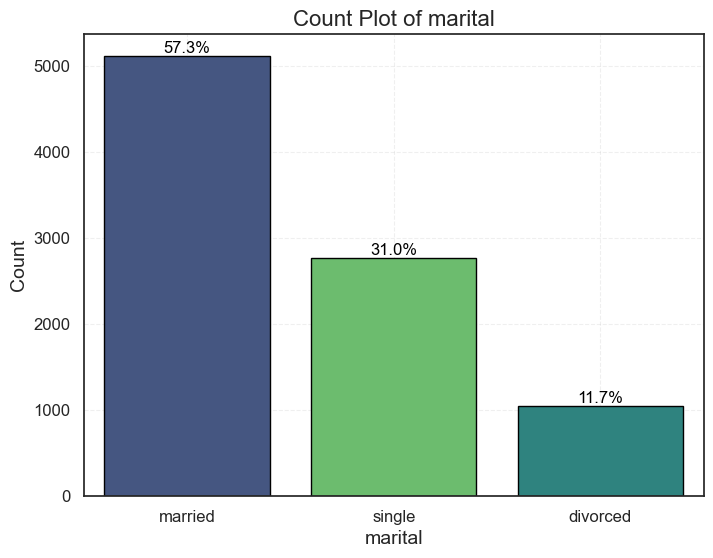

<Axes: title={'center': 'Count Plot of marital'}, xlabel='marital', ylabel='Count'>

In [23]:
target_plot = 'marital'
count_plot(df,target_plot,palette='viridis',order=True)


# Show the distribution of customers based on their education levels(in graph)

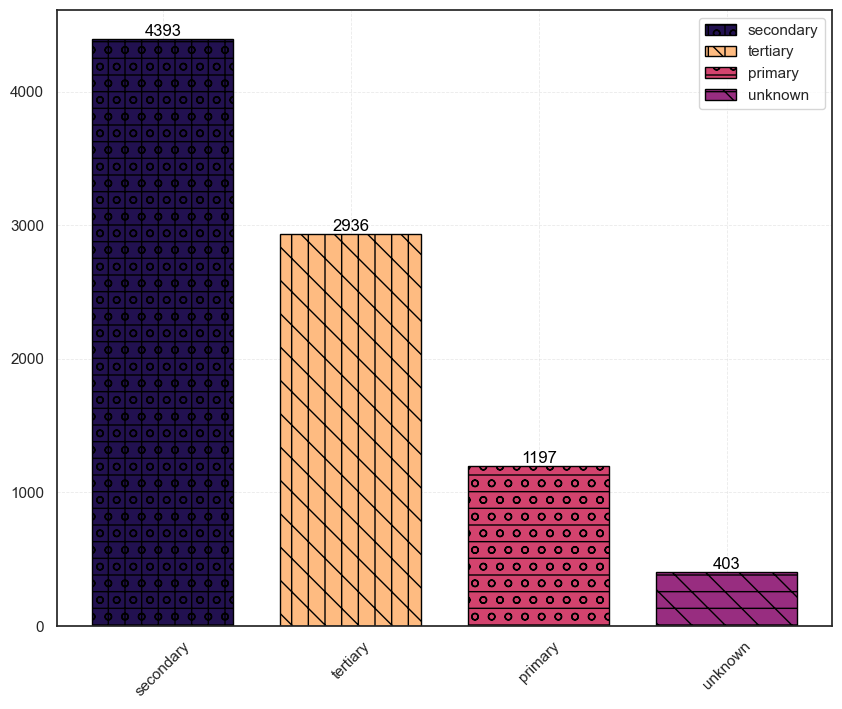

In [24]:
target_plot = 'education'
bar_plot_matplotlib(x=data[target_plot].value_counts().index,y=data[target_plot].value_counts().values,order=True)

# How many people took out a housing loan?(in graph)

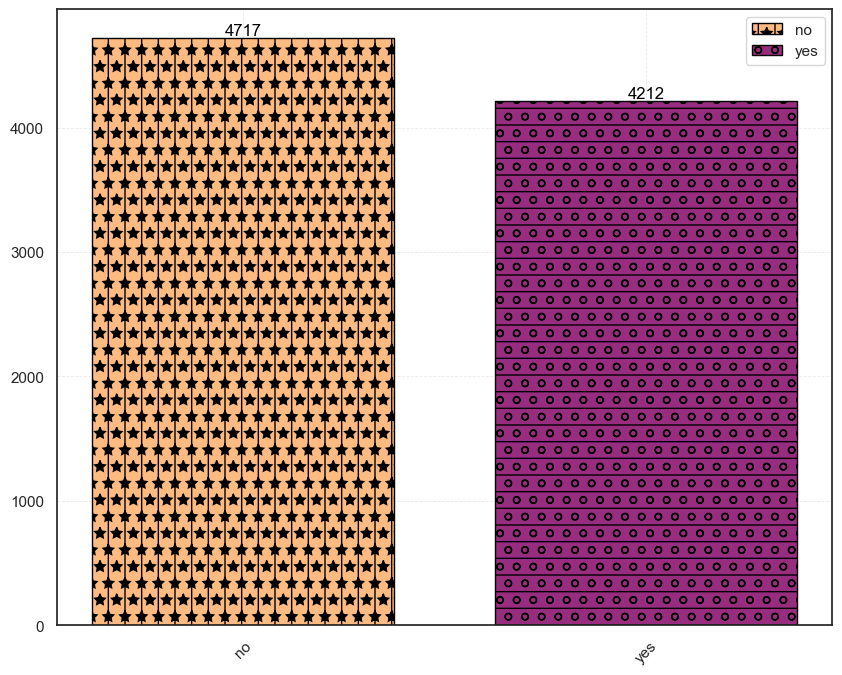

In [25]:
target_plot = 'housing'

bar_plot_matplotlib(x=data[target_plot].value_counts().index,y=data[target_plot].value_counts().values,order=True)

# How many people took out a personal loan?(in graph)

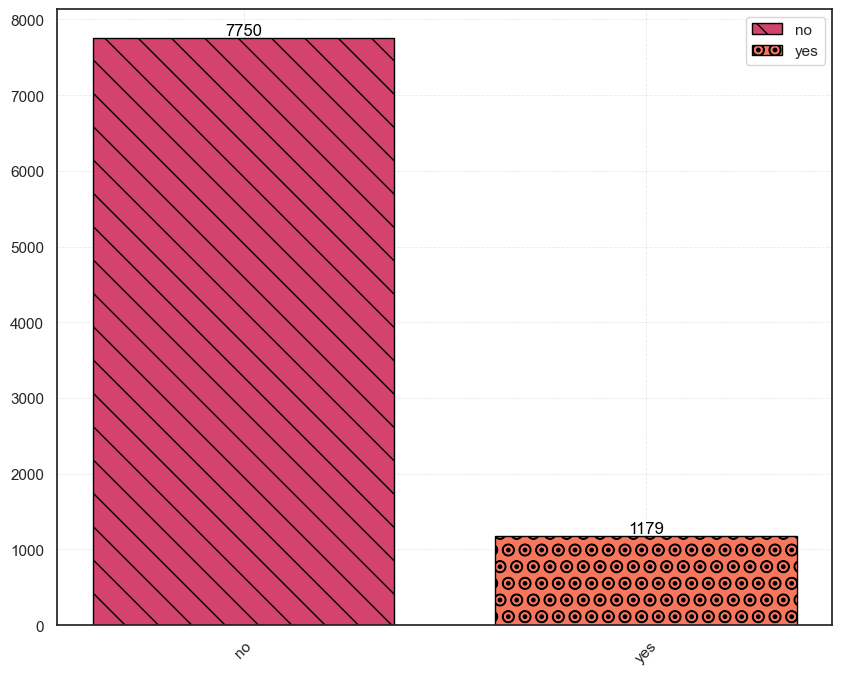

In [26]:
target_plot = 'loan'

bar_plot_matplotlib(x=data[target_plot].value_counts().index,y=data[target_plot].value_counts().values,order=True)

# Show the distribution of the months when customers were contacted(in graph)

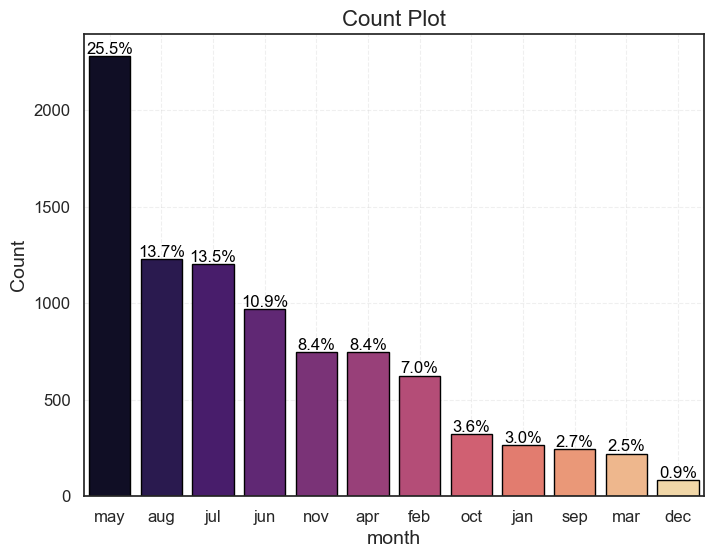

In [27]:
target_plot = 'month'
plt.figure(figsize=(8, 6))  # Set the figure size
ax = sns.countplot(data=df, 
                x=target_plot, 
                palette='magma', 
                order=df[target_plot].value_counts().index, 
                edgecolor='black')
# Add percentages on the bars
total = len(df[target_plot])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=12, 
                color='black', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.xlabel(target_plot, fontsize=14)  # Set x-axis label with font size
plt.ylabel('Count', fontsize=14)  # Set y-axis label with font size
plt.title('Count Plot', fontsize=16)  # Set title with font size
plt.grid(True, linestyle='--', linewidth=0.8, alpha=0.3)  # Add grid lines with custom style
plt.xticks(fontsize=12)  # Set font size for x-axis ticks
plt.yticks(fontsize=12)  # Set font size for y-axis ticks
plt.show()

# Visualize the distribution of customer ages to understand the age demographics of the dataset

In [28]:
def plot_histograms_seaborn(df: pd.DataFrame, column: Optional[Union[str, None]] = None, save_plots: bool = False, palette: str = 'magma',
                            bins: Optional[Union[int, list]] = 25, edgecolor: str = 'black', alpha: float = 0.9, kde: bool = True,
                            multiple: Literal['layer', 'dodge', 'stack', 'fill'] = 'layer') -> None:
    """
    Plots histograms for numerical columns in the dataframe using Seaborn.
    
    Parameters:
    df (pd.DataFrame): The input dataframe.
    column (Union[str, None], optional): The specific column to plot. If None, plot all numerical columns.
    save_plots (bool, optional): Whether to save the plots as images. Default is False.
    palette (str, optional): The color palette to use for the plots. Default is 'magma'.
    bins (Union[int, list], optional): Number of bins or bin edges for the histogram. Default is None.
    edgecolor (str, optional): Color of the edge of the bins. Default is 'black'.
    alpha (float, optional): Transparency level of the bins. Default is 0.9.
    kde (bool, optional): Whether to plot a KDE. Default is True.
    multiple (Literal['layer', 'dodge', 'stack', 'fill'], optional): How to plot multiple elements. Default is 'layer'.
    
    Returns:
    None
    """
    
    def plot_single_histogram(col_data: pd.Series, col_name: str, color: str) -> None:
        plt.figure(figsize=(8, 6))
        sns.histplot(col_data, kde=kde, color=color, bins=bins, edgecolor=edgecolor, alpha=alpha, multiple=multiple)
        plt.title(f"Histogram for {col_name}")
        plt.tight_layout()
        if save_plots:
            plt.savefig(f"histogram_{col_name}.png")
        plt.show()
    
    def plot_all_histograms(numerical_cols: pd.DataFrame) -> None:
        num_columns = len(numerical_cols.columns)
        ncols = int(np.ceil(np.sqrt(num_columns)))
        nrows = int(np.ceil(num_columns / ncols))
        colors = sns.color_palette(palette, num_columns)

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 12))
        for index, col in enumerate(numerical_cols.columns):
            ax = axes.flatten()[index]
            sns.histplot(df[col], kde=kde, color=colors[index], bins=bins, edgecolor=edgecolor, alpha=alpha, multiple=multiple, ax=ax)
            ax.set_title(col)

        # Remove empty subplots
        for i in range(num_columns, nrows * ncols):
            fig.delaxes(axes.flatten()[i])

        plt.suptitle("Histograms of Numerical Columns", size=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if save_plots:
            plt.savefig("all_histograms.png")
        plt.show()
    
    try:
        numerical_columns = df.select_dtypes(include=['int64', 'float64'])
        
        if column is None or column.lower() == 'all':
            plot_all_histograms(numerical_columns)
        else:
            if column in numerical_columns.columns:
                color = sns.color_palette(palette, 1)[0]
                plot_single_histogram(df[column], column, color)
            else:
                print(f"Column '{column}' is not a numerical column in the dataframe.")
    except Exception as e:
        print(f"An error occurred: {e}")




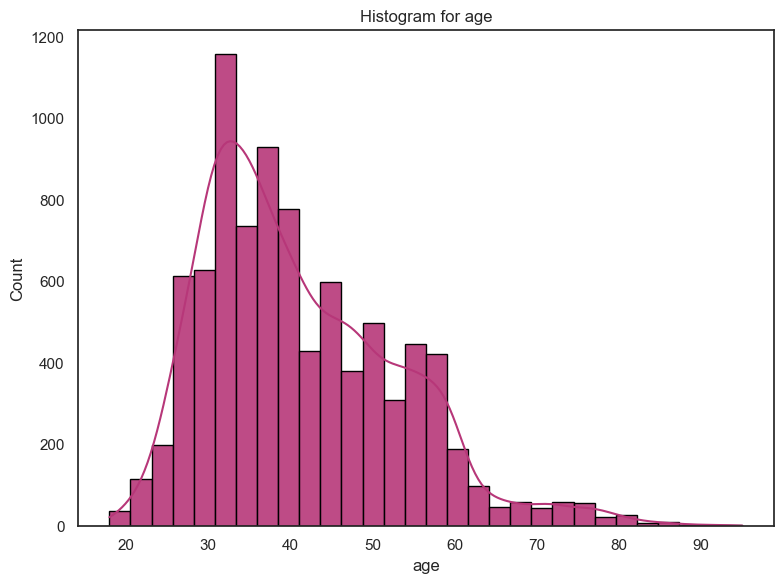

In [29]:
target_plot = 'age'

plot_histograms_seaborn(df,target_plot,bins=30)

# Correlation Analysis

In [30]:
def heatmap_plot(df, 
                annot=True, 
                fmt=".2f", 
                cmap="YlGnBu", 
                linewidths=0.1, 
                linecolor='black', 
                square=True, 
                mask=None, 
                robust=True, 
                title=None, 
                xlabel=None, 
                ylabel=None, 
                figsize=(14, 8)):
    """
    Create a customized heatmap from the given DataFrame.

    Parameters:
    df (pd.DataFrame): The data for the heatmap.
    annot (bool): Annotate cells with the data value. Default is True.
    fmt (str): String formatting code to use when adding annotations. Default is ".2f".
    cmap (str): Colormap. Default is "YlGnBu".
    linewidths (float): Width of the lines that will divide each cell. Default is 0.3.
    linecolor (str): Color of the lines that will divide each cell. Default is 'black'.
    square (bool): If True, set the Axes aspect to “equal” so each cell will be square-shaped. Default is True.
    mask (pd.DataFrame or np.ndarray): If passed, data will not be shown in cells where mask is True. Default is None.
    robust (bool): If True and vmin or vmax are absent, the colormap range is computed with robust quantiles instead of the extreme values. Default is True.
    title (str): Title for the heatmap. Default is None.
    xlabel (str): Label for the x-axis. Default is None.
    ylabel (str): Label for the y-axis. Default is None.
    figsize (tuple): Size of the figure. Default is (14, 8).

    Returns:
    None
    """
    # Set default labels if None
    if xlabel is None:
        xlabel = 'X'
    if ylabel is None:
        ylabel = 'Y'
    if title is None:
        title = 'Customized Seaborn Heatmap'

    # Create a figure and axis with specified figure size
    plt.figure(figsize=figsize)
    
    # Create the heatmap with customization
    heatmap = sns.heatmap(
        data=df,
        annot=annot,             # Annotate cells with the data value
        fmt=fmt,                 # Format the annotations
        cmap=cmap,               # Colormap
        linewidths=linewidths,   # Line width between cells
        linecolor=linecolor,     # Line color between cells
        square=square,           # Force square cells
        mask=mask,               # Mask cells
        robust=robust            # Robust colormap limits
    )

    # Customize the plot title and axis labels
    plt.title(title, fontsize=18, weight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14, weight='bold')
    plt.ylabel(ylabel, fontsize=14, weight='bold')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Adjust layout to fit elements properly
    plt.tight_layout()

    # Add grid lines for better readability of the heatmap
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

    # Show the heatmap
    plt.show()



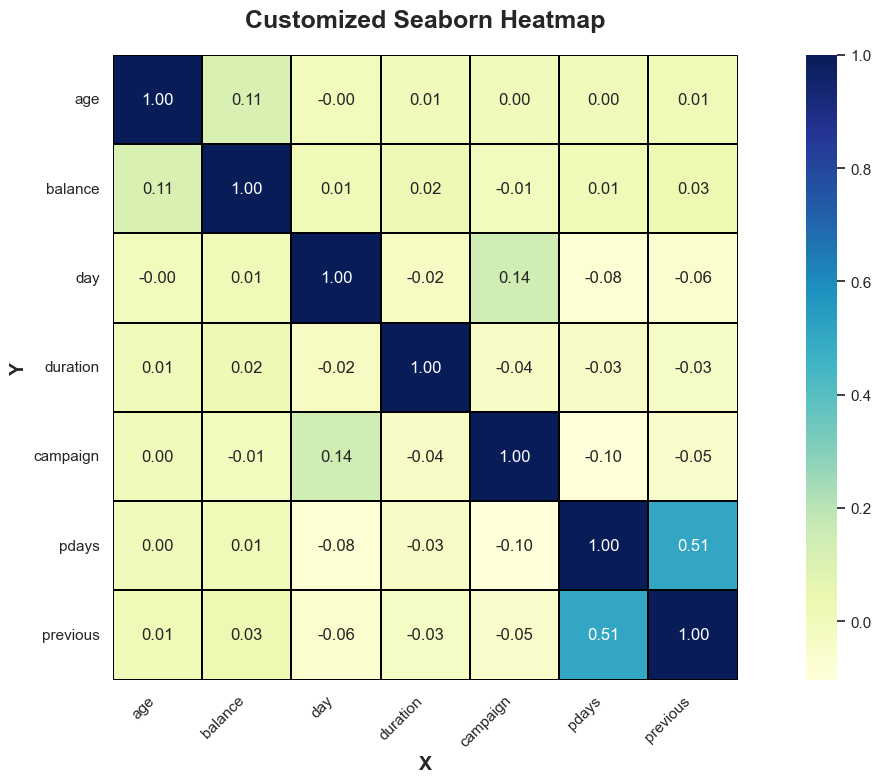

In [31]:
numeric_columns = df.select_dtypes(include=['int64', 'float64'])
correlations = numeric_columns.corr()
heatmap_plot(correlations)

# Encoding

In [32]:
df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

In [33]:
def encode_column(
    df: pd.DataFrame, 
    columns: Union[str, List[str]], 
    method: Literal[
        'get_dummies', 'label', 'ordinal', 'binary', 'target', 'dict_vectorizer', 
        'feature_hasher', 'label_binarizer', 'multi_label_binarizer'
    ] = 'get_dummies', 
    ordinal_categories: Optional[List[str]] = None, 
    target: Optional[str] = None, 
    n_features: Optional[int] = None,
    binary_default: bool = True
) -> pd.DataFrame:
    """
    Encodes one or more columns in the dataframe using the specified method.

    Parameters:
    ----------
    df (pd.DataFrame): The dataframe containing the column(s) to be encoded.
    columns (Union[str, List[str]]): The name of the column or a list of column names to be encoded.
    method (Literal['get_dummies', 'label', 'ordinal', 'binary', 'target', 
                    'dict_vectorizer', 'feature_hasher', 'label_binarizer', 
                    'multi_label_binarizer']): The encoding method to use. 
                    Options are 'get_dummies' (one_hot), 'label', 'ordinal', 
                    'binary', 'target', 'dict_vectorizer', 'feature_hasher', 
                    'label_binarizer', 'multi_label_binarizer'. Default is 'get_dummies'.
    ordinal_categories (Optional[List[str]]): Categories for ordinal encoding if method is 'ordinal'. Default is None.
    target (Optional[str]): Target column for target encoding. Default is None.
    n_features (Optional[int]): Number of features for feature hasher. Default is None.
    
    Examples:
    --------
    One-hot encoding for a single column
    >>> df_encoded = encode_column(df, 'column_name', method='get_dummies')
    Ordinal encoding with specified categories
    >>> df_encoded = encode_column(df, 'column_name', method='ordinal', ordinal_categories=['low', 'medium', 'high'])
    Binary encoding for a single column
    >>> df_encoded = encode_column(df, 'column_name', method='binary')
    Target encoding for a single column
    >>> df_encoded = encode_column(df, 'column_name', method='target', target='target_column')
    Feature hashing with a specified number of features
    >>> df_encoded = encode_column(df, 'column_name', method='feature_hasher', n_features=10)

    Returns:
    -------
    pd.DataFrame: The dataframe with the encoded column(s).

    """
    
    def binary_encode(df: pd.DataFrame, column: str) -> pd.DataFrame:
        """Binary encodes a column with exactly two unique values, leaving NaN values unchanged."""
        unique_vals = df[column].dropna().unique()
        if len(unique_vals) != 2:
            raise ValueError("Column must have exactly two unique non-NaN values.")
        df[column] = df[column].apply(lambda x: 1 if x == unique_vals[0] else (0 if x == unique_vals[1] else np.nan))
        return df

    def label_encode(df: pd.DataFrame, column: str) -> pd.DataFrame:
        """Label encodes a column, preserving NaN values."""
        le = LabelEncoder()
        non_nan_mask = df[column].notna()
        le.fit(df.loc[non_nan_mask, column])
        df.loc[non_nan_mask, column] = le.transform(df.loc[non_nan_mask, column])
        return df

    def ordinal_encode(df: pd.DataFrame, column: str, categories: List[str]) -> pd.DataFrame:
        """Ordinal encodes a column with provided categories, preserving NaN values."""
        oe = OrdinalEncoder(categories=[categories], handle_unknown='use_encoded_value', unknown_value=np.nan)
        nan_mask = df[column].isna()
        df[column] = oe.fit_transform(df[[column]])
        df.loc[nan_mask, column] = np.nan
        return df

    def get_dummies(df: pd.DataFrame, column: str) -> pd.DataFrame:
        """One-hot encodes a column, preserving NaN values."""
        nan_mask = df[column].isna()
        dummies = pd.get_dummies(df[column], drop_first=True, dtype=float)
        df = pd.concat([df, dummies], axis=1)
        df.loc[nan_mask, dummies.columns] = pd.NA
        df = df.drop(column, axis=1)
        return df

    def target_encode(df: pd.DataFrame, column: str, target: str) -> pd.DataFrame:
        """Target encodes a column based on the target column."""
        te = TargetEncoder(cols=[column])
        df[column] = te.fit_transform(df[column], df[target])
        return df

    def dict_vectorize(df: pd.DataFrame, column: str) -> pd.DataFrame:
        """Encodes a column using DictVectorizer."""
        dv = DictVectorizer(sparse=False)
        dict_data = df[column].apply(lambda x: {column: x})
        transformed = dv.fit_transform(dict_data)
        df = df.drop(column, axis=1)
        df = pd.concat([df, pd.DataFrame(transformed, columns=dv.get_feature_names_out())], axis=1)
        return df

    def feature_hash(df: pd.DataFrame, column: str, n_features: int) -> pd.DataFrame:
        """Encodes a column using FeatureHasher."""
        fh = FeatureHasher(n_features=n_features, input_type='string')
        transformed = fh.transform(df[column].astype(str)).toarray()
        df = df.drop(column, axis=1)
        df = pd.concat([df, pd.DataFrame(transformed, columns=[f'{column}_hashed_{i}' for i in range(n_features)])], axis=1)
        return df

    def label_binarize(df: pd.DataFrame, column: str) -> pd.DataFrame:
        """Label binarizes a column."""
        lb = LabelBinarizer()
        transformed = lb.fit_transform(df[column])
        df = df.drop(column, axis=1)
        df = pd.concat([df, pd.DataFrame(transformed, columns=lb.classes_)], axis=1)
        return df

    def multi_label_binarize(df: pd.DataFrame, column: str) -> pd.DataFrame:
        """Multi-label binarizes a column."""
        mlb = MultiLabelBinarizer()
        transformed = mlb.fit_transform(df[column])
        df = df.drop(column, axis=1)
        df = pd.concat([df, pd.DataFrame(transformed, columns=mlb.classes_)], axis=1)
        return df

    if isinstance(columns, str):
        columns = [columns]
    
    
    if binary_default:
        for column in columns:
            if column not in df.columns:
                raise ValueError(f"Column '{column}' does not exist in the dataframe")
            
            unique_vals = df[column].value_counts()
            
            # If the column is binary (contains exactly two unique values)
            if len(unique_vals) == 2:
                df = binary_encode(df, column)
            else:
            # Handle other encoding methods based on the method parameter
                if method == 'binary':
                    df = binary_encode(df, column)
                elif method == 'label':
                    df = label_encode(df, column)
                elif method == 'ordinal':
                    if ordinal_categories is None:
                        raise ValueError("ordinal_categories must be provided for ordinal encoding")
                    df = ordinal_encode(df, column, ordinal_categories)
                elif method == 'get_dummies':
                    df = get_dummies(df, column)
                elif method == 'target':
                    if target is None:
                        raise ValueError("Target column must be provided for target encoding")
                    df = target_encode(df, column, target)
                elif method == 'dict_vectorizer':
                    df = dict_vectorize(df, column)
                elif method == 'feature_hasher':
                    if n_features is None:
                        raise ValueError("Number of features must be provided for feature hasher")
                    df = feature_hash(df, column, n_features)
                elif method == 'label_binarizer':
                    df = label_binarize(df, column)
                elif method == 'multi_label_binarizer':
                    df = multi_label_binarize(df, column)
                else:
                    raise ValueError(f"Encoding method '{method}' is not supported")
    
    else:
        for column in columns:
            if column not in df.columns:
                raise ValueError(f"Column '{column}' does not exist in the dataframe")

            if method == 'binary':
                df = binary_encode(df, column)
            elif method == 'label':
                df = label_encode(df, column)
            elif method == 'ordinal':
                if ordinal_categories is None:
                    raise ValueError("ordinal_categories must be provided for ordinal encoding")
                df = ordinal_encode(df, column, ordinal_categories)
            elif method == 'get_dummies':
                df = get_dummies(df, column)
            elif method == 'target':
                if target is None:
                    raise ValueError("Target column must be provided for target encoding")
                df = target_encode(df, column, target)
            elif method == 'dict_vectorizer':
                df = dict_vectorize(df, column)
            elif method == 'feature_hasher':
                if n_features is None:
                    raise ValueError("Number of features must be provided for feature hasher")
                df = feature_hash(df, column, n_features)
            elif method == 'label_binarizer':
                df = label_binarize(df, column)
            elif method == 'multi_label_binarizer':
                df = multi_label_binarize(df, column)
            else:
                raise ValueError(f"Encoding method '{method}' is not supported")
    return df



In [35]:
df = encode_column(df, columns = 'deposit', method='get_dummies')

In [36]:
column = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

df = encode_column(df, columns = column, method='target',target='deposit',binary_default=False)

# df = encode_column(df, columns = '', method= 'label')

# ordinal_categories = df['Dependents'].value_counts().index.to_list()
# df = encode_column(df, columns = '', method= 'ordinal', ordinal_categories=ordinal_categories)

df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

[]

In [37]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,49,0.485446,0.561486,0.549283,0.520423,104,0.634615,0.499484,0.776952,8,0.669886,285,1,-1,0,0.591149,1
1,59,0.336013,0.506196,0.549283,0.520423,514,0.422938,0.499484,0.450132,3,0.431090,261,1,-1,0,0.591149,0
2,33,0.624838,0.561486,0.602339,0.520423,195,0.422938,0.499484,0.450132,16,0.556894,984,5,-1,0,0.591149,0
3,58,0.405694,0.561486,0.549283,0.520423,687,0.634615,0.499484,0.450132,7,0.538712,221,1,99,2,0.086957,0
4,33,0.528598,0.561486,0.549283,0.520423,1077,0.634615,0.499484,0.450132,18,0.669886,432,3,374,3,0.419725,1


In [38]:
# Make the target is last column

target = 'deposit'

target_column = df[target]
df.drop(columns=[target], inplace=True)
df[target] = target_column

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,49,0.485446,0.561486,0.549283,0.520423,104,0.634615,0.499484,0.776952,8,0.669886,285,1,-1,0,0.591149,1
1,59,0.336013,0.506196,0.549283,0.520423,514,0.422938,0.499484,0.450132,3,0.431090,261,1,-1,0,0.591149,0
2,33,0.624838,0.561486,0.602339,0.520423,195,0.422938,0.499484,0.450132,16,0.556894,984,5,-1,0,0.591149,0
3,58,0.405694,0.561486,0.549283,0.520423,687,0.634615,0.499484,0.450132,7,0.538712,221,1,99,2,0.086957,0
4,33,0.528598,0.561486,0.549283,0.520423,1077,0.634615,0.499484,0.450132,18,0.669886,432,3,374,3,0.419725,1


# Handling UnBalance data if found

In [40]:
target = 'deposit'

x=df.drop(target,axis=1)
y=df[target]

In [41]:
# the data is balance but the code is:
def over_under_sampling_classification(x, 
                        y, 
                        over_sampling = None, 
                        under_sampling = None, 
                        over_sampling_strategy = 0.5, 
                        under_sampling_strategy = 0.5, 
                        k_neighbors = 5, 
                        random_state = 42, 
                        over = True, 
                        under = True):
    print(f'Initial class distribution: {Counter(y)}', )
    # Over-sampling
    if over:
        if over_sampling is None:
            print(f'Applying SMOTE with strategy {over_sampling_strategy}')
            smote = SMOTE(sampling_strategy=over_sampling_strategy, random_state=random_state, k_neighbors=k_neighbors)
            x, y = smote.fit_resample(x, y)
        elif over_sampling == 'random_over_sampler':
            print(f'Applying RandomOverSampler with strategy {over_sampling_strategy}')
            ros = RandomOverSampler(sampling_strategy=over_sampling_strategy, random_state=random_state)
            x, y = ros.fit_resample(x, y)
        else:
            raise ValueError(f"Invalid over_sampling strategy '{over_sampling}' specified.")
    # Under-sampling
    if under:
        if under_sampling is None:
            print('Applying TomekLinks under-sampling.')
            tom = TomekLinks(n_jobs=-1)
            x, y = tom.fit_resample(x, y)
        elif under_sampling == 'random_under_sampler':
            print(f'Applying RandomUnderSampler with strategy {under_sampling_strategy}')
            rus = RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=random_state)
            x, y = rus.fit_resample(x, y)
        else:
            raise ValueError(f"Invalid under_sampling strategy '{under_sampling}' specified.")
    
    # Combine the resampled features and target into a single DataFrame
    df = pd.concat([x, y], axis=1)
    
    print(f'Final class distribution: {Counter(y)}')
    print('Over-sampling and/or under-sampling process completed.')

    return df, x, y


# df, x, y = over_under_sampling_classification(x,y,over_sampling_strategy=0.75)

## Split the data to train, test

In [42]:
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=.2, random_state=42)

In [43]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7143, 16)
(1786, 16)
(7143,)
(1786,)


## Scale Features

StandardScaler

In [44]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

# Applied models

In [45]:
name = ['SVM','knn','Random_forest','Decision_Tree']
scores = []

# 1- SVM With grid search and evaluate it using accuracy, comfusion matrix

In [46]:
svc = SVC()
params = {
    'C':[.1 ,1, 10],
    'kernel':['linear','poly','rbf'],
    'gamma':['auto','scale']
}
svm_grid_search = GridSearchCV(svc, params, scoring='accuracy', cv=5)

# Train the grid search
svm_grid_search.fit(x_train, y_train)  

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [47]:
print("Best Hyperparameters:", svm_grid_search.best_params_)
print("Best Cross-Validated Score:", svm_grid_search.best_score_)

Best Hyperparameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validated Score: 0.8346639145511248


In [48]:
# Get the model with best hyperparameters
svm_model = svm_grid_search.best_estimator_
y_pred = svm_model.predict(x_test)

In [49]:
svm_accuracy = accuracy_score(y_test , y_pred)
scores.append(svm_accuracy)
print(svm_accuracy)

0.8337066069428891


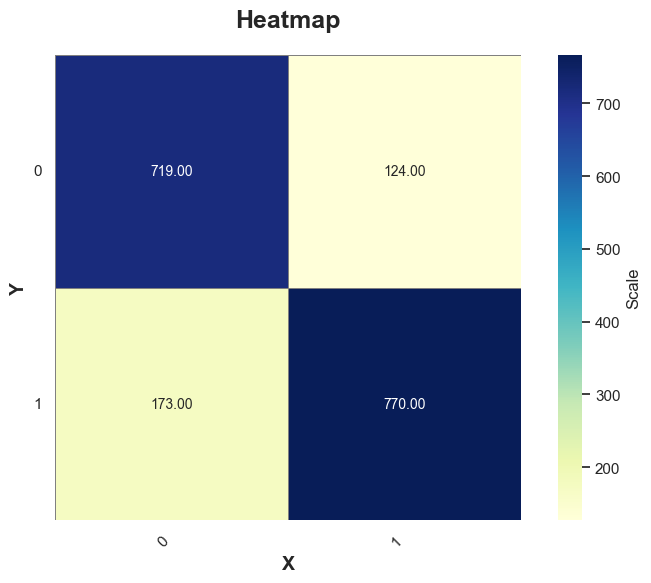

In [50]:
confusion=confusion_matrix(y_test , y_pred)

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Create a heatmap with customization
heatmap = sns.heatmap(
    data=confusion,
    annot=True,              # Annotate cells with the data value
    fmt=".2f",               # Format the annotations to 2 decimal places
    cmap="YlGnBu",           # Colormap
    cbar=True,               # Show color bar
    cbar_kws={'label': 'Scale'},  # Color bar customization
    linewidths=0.5,          # Line width between cells
    linecolor='gray',        # Line color between cells
    square=True,             # Force square cells
    mask=confusion<1,               # Do not mask any data
    annot_kws={"size": 10},  # Annotation font size
    xticklabels=True,        # Show x-axis labels
    yticklabels=True,        # Show y-axis labels
    robust=True              # Robust colormap limits
)

# Customize the plot
plt.title('Heatmap', fontsize=18, weight='bold', pad=20)
plt.xlabel('X', fontsize=14, weight='bold')
plt.ylabel('Y', fontsize=14, weight='bold')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Rotate y-axis labels
plt.yticks(rotation=0)

# Adjust layout for better fit
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.3)
# Display the heatmap
plt.show()

# 2- knn with grid search and evaluate it using accuracy, comfusion matrix

In [51]:
params = {'n_neighbors' : [3,5,7,9,11,13] , 'p' : [1,2] , 'weights': ["uniform", "distance"]}
knn = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn, params, scoring='accuracy', cv=5)  # Set refit=True

# Train the grid search
knn_grid_search.fit(x_train, y_train)  

  File "c:\Users\PC\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [52]:
print("Best Hyperparameters:", knn_grid_search.best_params_)
print("Best Cross-Validated Score:", knn_grid_search.best_score_)

Best Hyperparameters: {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Best Cross-Validated Score: 0.8038657030341877


In [53]:
# Get the model with best hyperparameters
knn_model = knn_grid_search.best_estimator_
y_pred = knn_model.predict(x_test)

In [54]:
knn_accuracy = accuracy_score(y_test , y_pred)
scores.append(knn_accuracy)
print(knn_accuracy)

0.8152295632698768


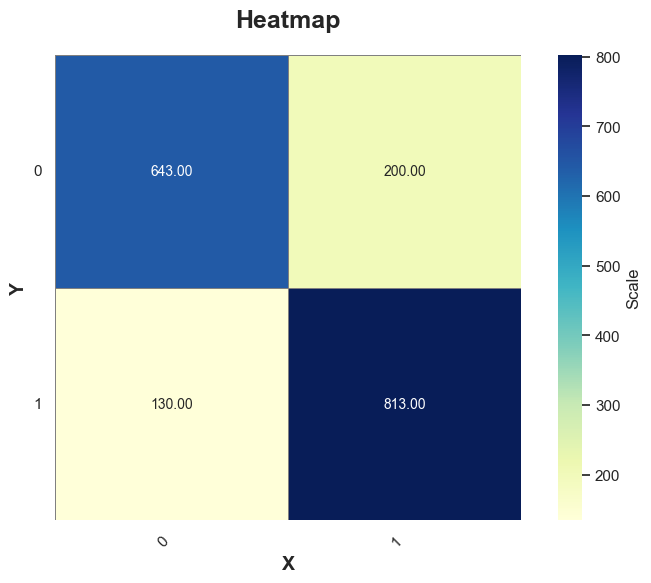

In [55]:
confusion=confusion_matrix(y_test , y_pred)

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Create a heatmap with customization
heatmap = sns.heatmap(
    data=confusion,
    annot=True,              # Annotate cells with the data value
    fmt=".2f",               # Format the annotations to 2 decimal places
    cmap="YlGnBu",           # Colormap
    cbar=True,               # Show color bar
    cbar_kws={'label': 'Scale'},  # Color bar customization
    linewidths=0.5,          # Line width between cells
    linecolor='gray',        # Line color between cells
    square=True,             # Force square cells
    mask=confusion<1,               # Do not mask any data
    annot_kws={"size": 10},  # Annotation font size
    xticklabels=True,        # Show x-axis labels
    yticklabels=True,        # Show y-axis labels
    robust=True              # Robust colormap limits
)

# Customize the plot
plt.title('Heatmap', fontsize=18, weight='bold', pad=20)
plt.xlabel('X', fontsize=14, weight='bold')
plt.ylabel('Y', fontsize=14, weight='bold')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Rotate y-axis labels
plt.yticks(rotation=0)

# Adjust layout for better fit
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.3)
# Display the heatmap
plt.show()

# 3- Random forest and evaluate it using accuracy, comfusion matrix

In [56]:
rf = RandomForestClassifier(random_state=42)
params = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}
rf_grid_search = GridSearchCV(rf, params, scoring='recall', cv=5)

rf_grid_search.fit(x_train, y_train) 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300]},
             scoring='recall')

In [57]:
print("Best Hyperparameters:", rf_grid_search.best_params_)
print("Best Cross-Validated Score:", rf_grid_search.best_score_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 100}
Best Cross-Validated Score: 0.8222818791946309


In [58]:
# Get the model with best hyperparameters
rf_model = rf_grid_search.best_estimator_
y_pred = rf_model.predict(x_test)

In [59]:
rf_accuracy = accuracy_score(y_test , y_pred)
scores.append(rf_accuracy)
print(rf_accuracy)

0.8437849944008958


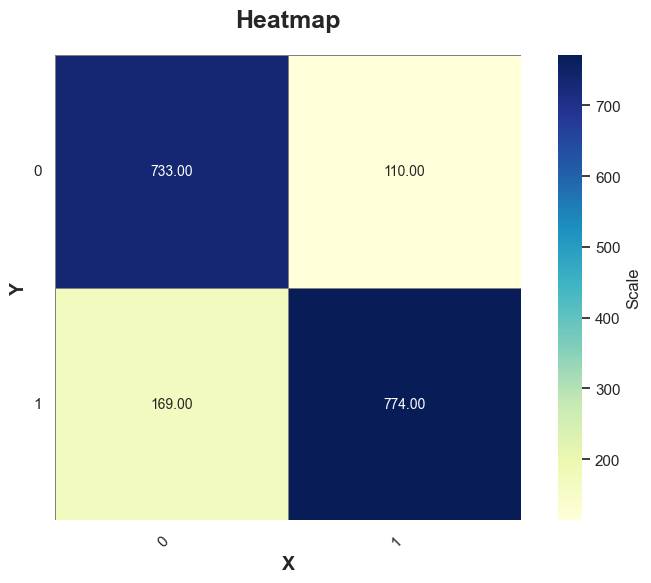

In [60]:
confusion=confusion_matrix(y_test , y_pred)

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Create a heatmap with customization
heatmap = sns.heatmap(
    data=confusion,
    annot=True,              # Annotate cells with the data value
    fmt=".2f",               # Format the annotations to 2 decimal places
    cmap="YlGnBu",           # Colormap
    cbar=True,               # Show color bar
    cbar_kws={'label': 'Scale'},  # Color bar customization
    linewidths=0.5,          # Line width between cells
    linecolor='gray',        # Line color between cells
    square=True,             # Force square cells
    mask=confusion<1,               # Do not mask any data
    annot_kws={"size": 10},  # Annotation font size
    xticklabels=True,        # Show x-axis labels
    yticklabels=True,        # Show y-axis labels
    robust=True              # Robust colormap limits
)

# Customize the plot
plt.title('Heatmap', fontsize=18, weight='bold', pad=20)
plt.xlabel('X', fontsize=14, weight='bold')
plt.ylabel('Y', fontsize=14, weight='bold')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Rotate y-axis labels
plt.yticks(rotation=0)

# Adjust layout for better fit
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.3)
# Display the heatmap
plt.show()

# 4- Decision Tree classifier and evaluate it using accuracy, comfusion matrix

In [61]:
decision_tree = DecisionTreeClassifier()
params = {
    'criterion':['gini', 'entropy'],
    'max_depth':[3,4,5,6,7,8,9,10]
}
decision_tree_grid_search = GridSearchCV(decision_tree, params, scoring='recall', cv=5)

# Train the grid search
decision_tree_grid_search.fit(x_train, y_train)  

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='recall')

In [62]:
print("Best Hyperparameters:", decision_tree_grid_search.best_params_)
print("Best Cross-Validated Score:", decision_tree_grid_search.best_score_)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5}
Best Cross-Validated Score: 0.8064429530201342


In [63]:
# Get the model with best hyperparameters
decision_tree_model = decision_tree_grid_search.best_estimator_
y_pred = decision_tree_model.predict(x_test)

In [64]:
decision_tree_accuracy = accuracy_score(y_test , y_pred)
scores.append(decision_tree_accuracy)
print(decision_tree_accuracy)

0.8012318029115342


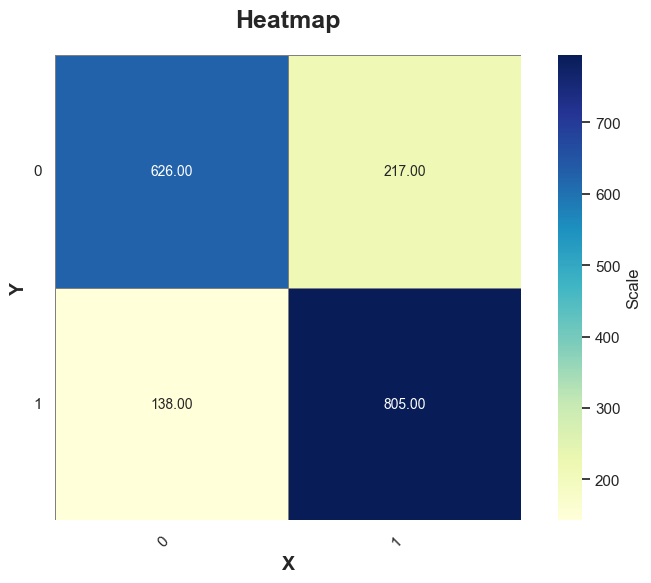

In [65]:
confusion=confusion_matrix(y_test , y_pred)

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Create a heatmap with customization
heatmap = sns.heatmap(
    data=confusion,
    annot=True,              # Annotate cells with the data value
    fmt=".2f",               # Format the annotations to 2 decimal places
    cmap="YlGnBu",           # Colormap
    cbar=True,               # Show color bar
    cbar_kws={'label': 'Scale'},  # Color bar customization
    linewidths=0.5,          # Line width between cells
    linecolor='gray',        # Line color between cells
    square=True,             # Force square cells
    mask=confusion<1,               # Do not mask any data
    annot_kws={"size": 10},  # Annotation font size
    xticklabels=True,        # Show x-axis labels
    yticklabels=True,        # Show y-axis labels
    robust=True              # Robust colormap limits
)

# Customize the plot
plt.title('Heatmap', fontsize=18, weight='bold', pad=20)
plt.xlabel('X', fontsize=14, weight='bold')
plt.ylabel('Y', fontsize=14, weight='bold')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Rotate y-axis labels
plt.yticks(rotation=0)

# Adjust layout for better fit
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.3)
# Display the heatmap
plt.show()

# Compare among models in Bar graph using accuracy

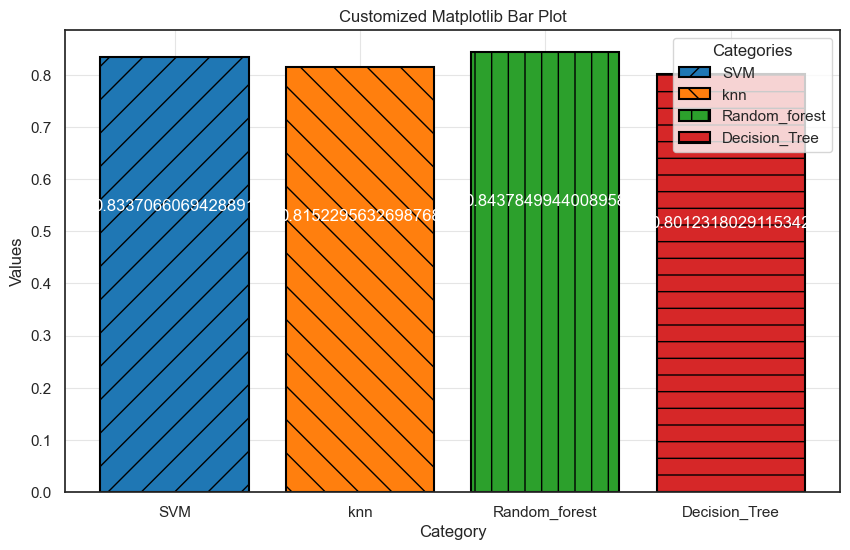

In [66]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
hatches = ['/', '\\', '|', '-']

# Create figure and axis
plt.figure(figsize=(10, 6))

# Plot data
bars = plt.bar(name, scores, color=colors, edgecolor='black', linewidth=1.5, hatch=hatches)

# Customize plot
plt.title('Customized Matplotlib Bar Plot')
plt.xlabel('Category')
plt.ylabel('Values')
plt.grid(True, linewidth=0.8, alpha=0.5)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 0.3, f'{height}', ha='center', va='bottom', color='white')

# Add legend
plt.legend(bars, name, title='Categories')

# Display plot
plt.show()